# ABC calibration of $I_\text{Na}$ in Courtemanche model to original dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used in the publication:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant [Sakakibara1992]
 - Recovery time constant [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

In [5]:
modelfile = 'models/courtemanche_ina.mmt'

# Activation gate ($m$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [16]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum_cou_adjust)

In [17]:
assert len(observations)==len(summary_statistics(model({})))

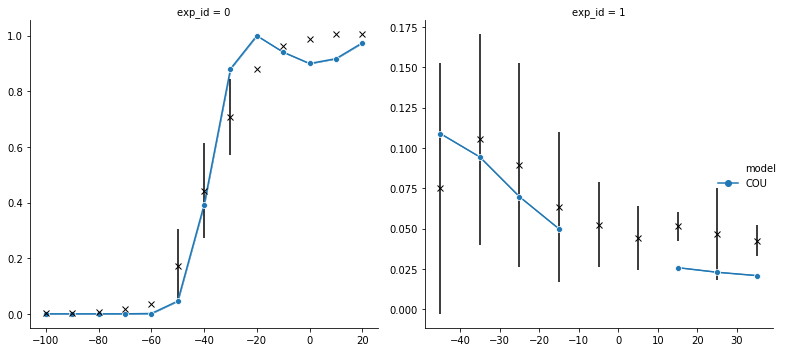

In [19]:
# Test the output of the unaltered model.
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum_cou_adjust)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [24]:
limits = {'ina.a1_m': (-100, 0),
          'ina.a2_m': (0, 1),
          'ina.a3_m': (0, 1),
          'ina.a4_m': (0, 10),
          'ina.b1_m': (0, 10),
          'ina.b2_m': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [25]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [26]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_mgate_original.db"))

In [27]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [28]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [30]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5570757359362264, '1': 1.5570757359362264, '2': 1.5570757359362264, '3': 1.5570757359362264, '4': 1.5570757359362264, '5': 0.5904911622959486, '6': 0.45939980914873735, '7': 0.5710013425594168, '8': 1.5570757359362264, '9': 1.5570757359362264, '10': 1.5570757359362264, '11': 1.5570757359362264, '12': 1.5570757359362264, '13': 0.15235445469736852, '14': 0.1819349064747563, '15': 0.1879980741832115, '16': 0.25507625823484376, '17': 0.4491978085688121, '18': 0.5936989296806218, '19': 1.3185718986681156, '20': 0.4160669679218102, '21': 1.2534510282040947}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [31]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [32]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-19 11:31:55.095938, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [33]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 20.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 3517.
INFO:ABC:Acceptance rate: 2000 / 3517 = 5.6867e-01.
DEBUG:Epsilon:new eps, t=1, eps=1.1920110107351267
INFO:ABC:t: 1, eps: 1.1920110107351267.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 7776.
INFO:ABC:Acceptance rate: 2000 / 4259 = 4.6959e-01.
DEBUG:Epsilon:new eps, t=2, eps=0.8990569694575163
INFO:ABC:t: 2, eps: 0.8990569694575163.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 12190.
INFO:ABC:Acceptance rate: 2000 / 4414 = 4.5310e-01.
DEBUG:Epsilon:new eps, t=3, eps=0.8096494247442982
INFO:ABC:t: 3, eps: 0.8096494247442982.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 17388.
INFO:ABC:Acceptance rate: 2000 / 5198 = 3.8476e-01.
DEBUG:Epsilon:new eps, t=4, eps=0.750855943697584

DEBUG:Epsilon:new eps, t=32, eps=0.42767785702368233
INFO:ABC:t: 32, eps: 0.42767785702368233.
DEBUG:ABC:Now submitting population 32.
DEBUG:ABC:Population 32 done.
DEBUG:ABC:Total samples up to t = 32: 840214.
INFO:ABC:Acceptance rate: 2000 / 11259 = 1.7764e-01.
DEBUG:Epsilon:new eps, t=33, eps=0.4272103409556444
INFO:ABC:t: 33, eps: 0.4272103409556444.
DEBUG:ABC:Now submitting population 33.
DEBUG:ABC:Population 33 done.
DEBUG:ABC:Total samples up to t = 33: 854209.
INFO:ABC:Acceptance rate: 2000 / 13995 = 1.4291e-01.
DEBUG:Epsilon:new eps, t=34, eps=0.42683015417264375
INFO:ABC:t: 34, eps: 0.42683015417264375.
DEBUG:ABC:Now submitting population 34.
DEBUG:ABC:Population 34 done.
DEBUG:ABC:Total samples up to t = 34: 868660.
INFO:ABC:Acceptance rate: 2000 / 14451 = 1.3840e-01.
DEBUG:Epsilon:new eps, t=35, eps=0.42655086154392674
INFO:ABC:t: 35, eps: 0.42655086154392674.
DEBUG:ABC:Now submitting population 35.
DEBUG:ABC:Population 35 done.
DEBUG:ABC:Total samples up to t = 35: 884119.

### Analysis of results

In [34]:
history = History(db_path)

In [35]:
df, w = history.get_distribution(m=0)

In [36]:
df.describe()

name,ina.a1_m,ina.a2_m,ina.a3_m,ina.a4_m,ina.b1_m,ina.b2_m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-99.875803,0.145998,0.215455,4.868289,1.085277,20.074018
std,0.096275,0.000124,0.001506,2.723653,0.005912,0.069211
min,-99.999989,0.145752,0.210474,0.003857,1.067430,19.887022
25%,-99.947600,0.145909,0.214507,2.546949,1.081246,20.023639
50%,-99.897704,0.145973,0.215409,4.733125,1.084927,20.069865
75%,-99.827944,0.146059,0.216456,7.126737,1.089592,20.124146
max,-99.359168,0.146663,0.220172,9.999977,1.103101,20.273091


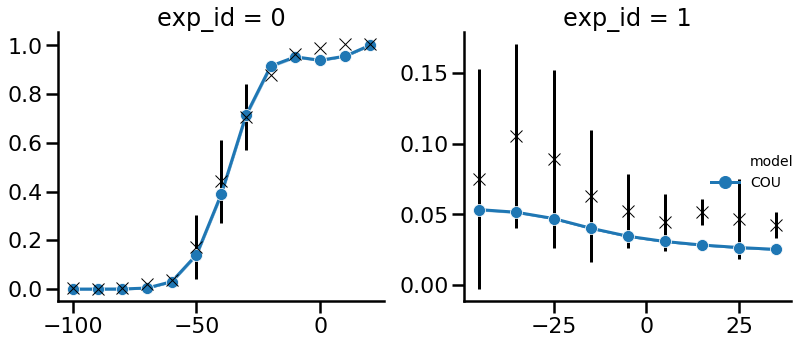

In [37]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum_cou_adjust,
                     df=df, w=w)

plt.tight_layout()

In [38]:
m,_,_ = myokit.load(modelfile)

In [39]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

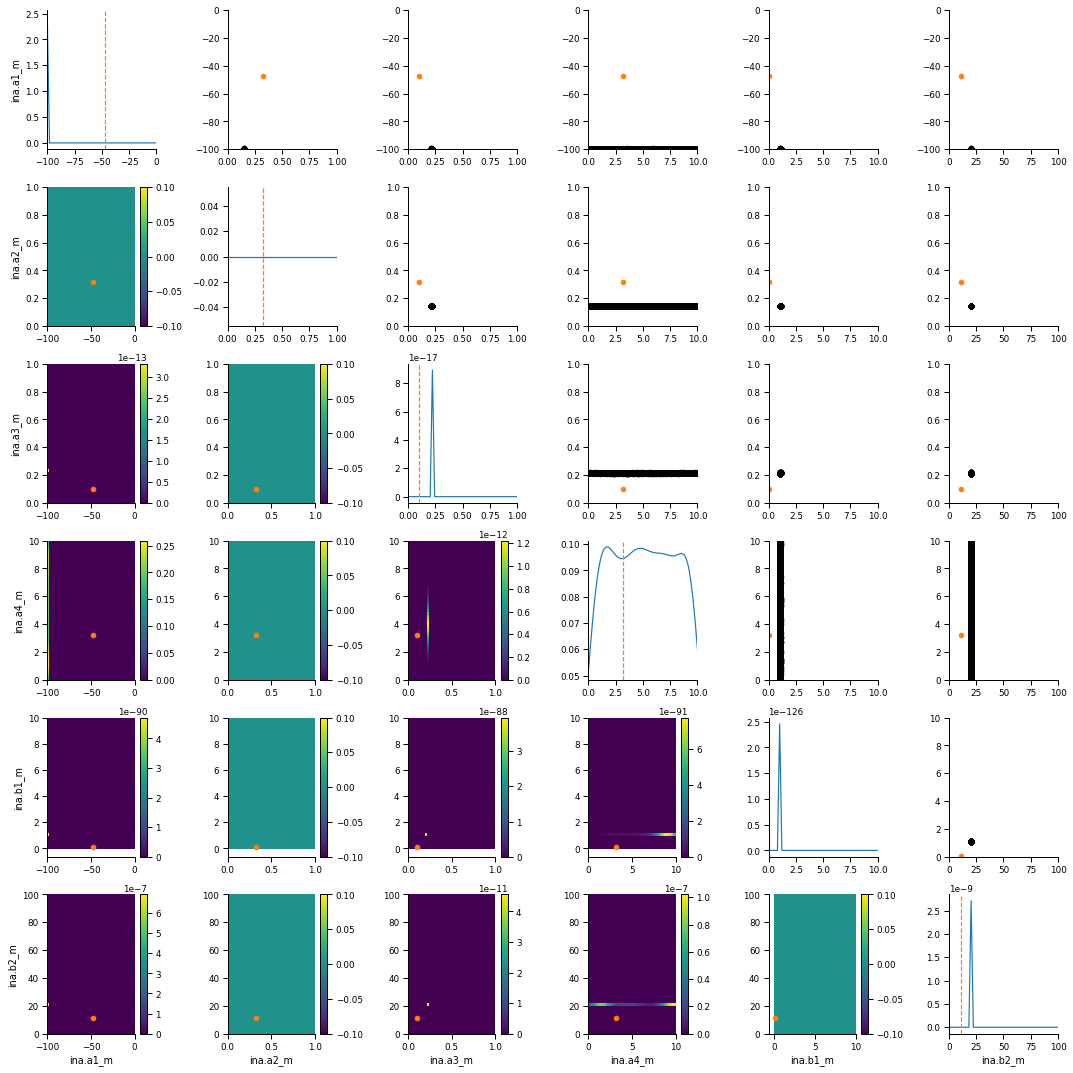

In [40]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Fast inactivation gate ($h$) calibration

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact_cou_adjust,
                                                sakakibara_inact_kin_fast_cou_adjust,
                                                sakakibara_rec_fast_cou_adjust)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

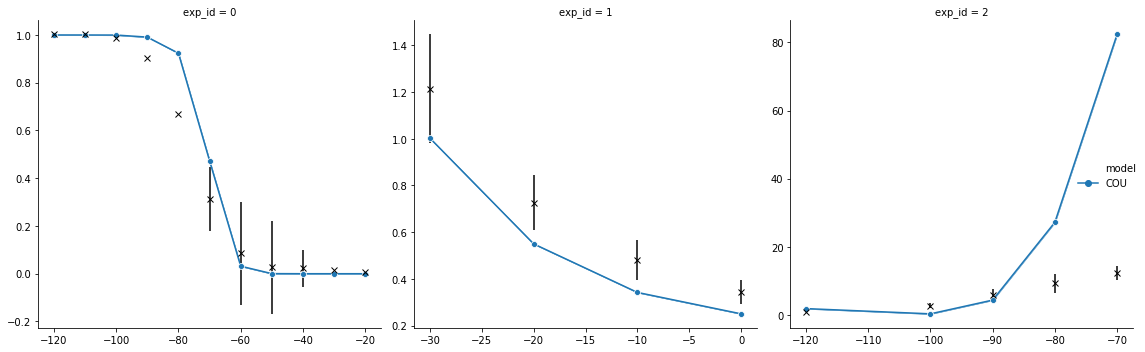

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_inact_cou_adjust,
                     sakakibara_inact_kin_fast_cou_adjust,
                     sakakibara_rec_fast_cou_adjust)

In [9]:
limits = {'ina.c1_h': (-100, 0),
          'log_ina.a1_h': (-2, 1),
          'ina.a2_h': (0, 50),
          'ina.a3_h': (0, 200),
          'ina.b2_h': (0, 100),
          'ina.b3_h': (0, 50),
          'log_ina.b4_h': (-1, 2),
          'log_ina.b5_h': (-3, 0),
          'log_ina.b6_h': (3, 6),
          'log_ina.b7_h': (-2, 1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
summary_statistics(model(prior.rvs()))

{'0': 0.9975858422617265,
 '1': 0.9974627058204689,
 '2': 0.9974870984338249,
 '3': 0.9944592195234383,
 '4': 0.9661312608965233,
 '5': 0.6829092262806274,
 '6': 0.1662969891163373,
 '7': 0.01663217010480187,
 '8': 1.544087931460735e-10,
 '9': 3.8241061891543885e-06,
 '10': -1.3380807686156046e-10,
 '11': 5.017197320804844,
 '12': 3.5947181581467964,
 '13': 3.0629702453271057,
 '14': 2.868538745242184,
 '15': 0.14631954846222775,
 '16': 0.48295832090343416,
 '17': 0.9113064992144112,
 '18': 2.236721091521449,
 '19': 6.323408613241784}

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_hgate_original.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9298311489289642, '1': 0.9298311489289642, '2': 0.9298311489289642, '3': 0.9298311489289642, '4': 0.9298311489289642, '5': 0.34877521029031383, '6': 0.21674341481487852, '7': 0.24006575158114657, '8': 0.5989135286482826, '9': 0.9298311489289642, '10': 0.9298311489289642, '11': 0.6679914857297752, '12': 1.3151082375304948, '13': 1.8297158087380803, '14': 2.5570356595546513, '15': 2.0456285276437214, '16': 1.901285628941935, '17': 0.7393593039114589, '18': 0.44622757416898995, '19': 0.5843318259435246}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-24 18:12:25.098801, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.


### Database results analysis

In [19]:
history = History(db_path)

In [20]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-12-24 18:12:25.098801, end_time=2019-12-25 04:46:04.211283)>]

In [21]:
df, w = history.get_distribution(m=0)

In [22]:
df.describe()

name,ina.a2_h,ina.a3_h,ina.b2_h,ina.b3_h,ina.c1_h,log_ina.a1_h,log_ina.b4_h,log_ina.b5_h,log_ina.b6_h,log_ina.b7_h
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,26.964270,88.508097,24.368373,18.548531,-32.363854,-0.348160,0.307530,-1.462810,4.434213,0.300084
std,5.808081,42.464716,23.564982,10.198298,22.027750,0.688205,0.616413,0.442898,0.810173,0.426152
min,11.383654,0.339995,0.026143,0.153184,-79.268905,-1.991852,-0.999735,-2.992745,3.003545,-0.835733
25%,22.815784,55.654679,8.732021,11.822355,-51.855608,-0.876120,-0.217853,-1.593039,3.733385,-0.001593
50%,26.807161,89.857272,15.919898,15.318698,-28.221729,-0.317193,0.541022,-1.315266,4.407137,0.355084
75%,30.919111,120.014206,29.601389,21.961660,-11.756408,0.182453,0.718996,-1.195146,5.116051,0.639597
max,45.599301,195.259843,99.707189,49.833306,-0.976855,0.992533,1.949545,-0.110172,5.998702,0.998932


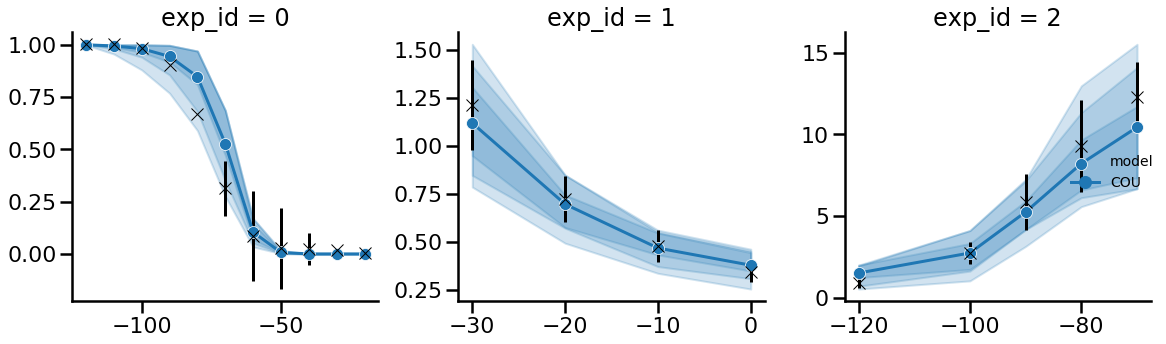

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_inact_cou_adjust,
                     sakakibara_inact_kin_fast_cou_adjust,
                     sakakibara_rec_fast_cou_adjust,
                     df=df, w=w)

plt.tight_layout()

In [24]:
m,_,_ = myokit.load(modelfile)

In [25]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

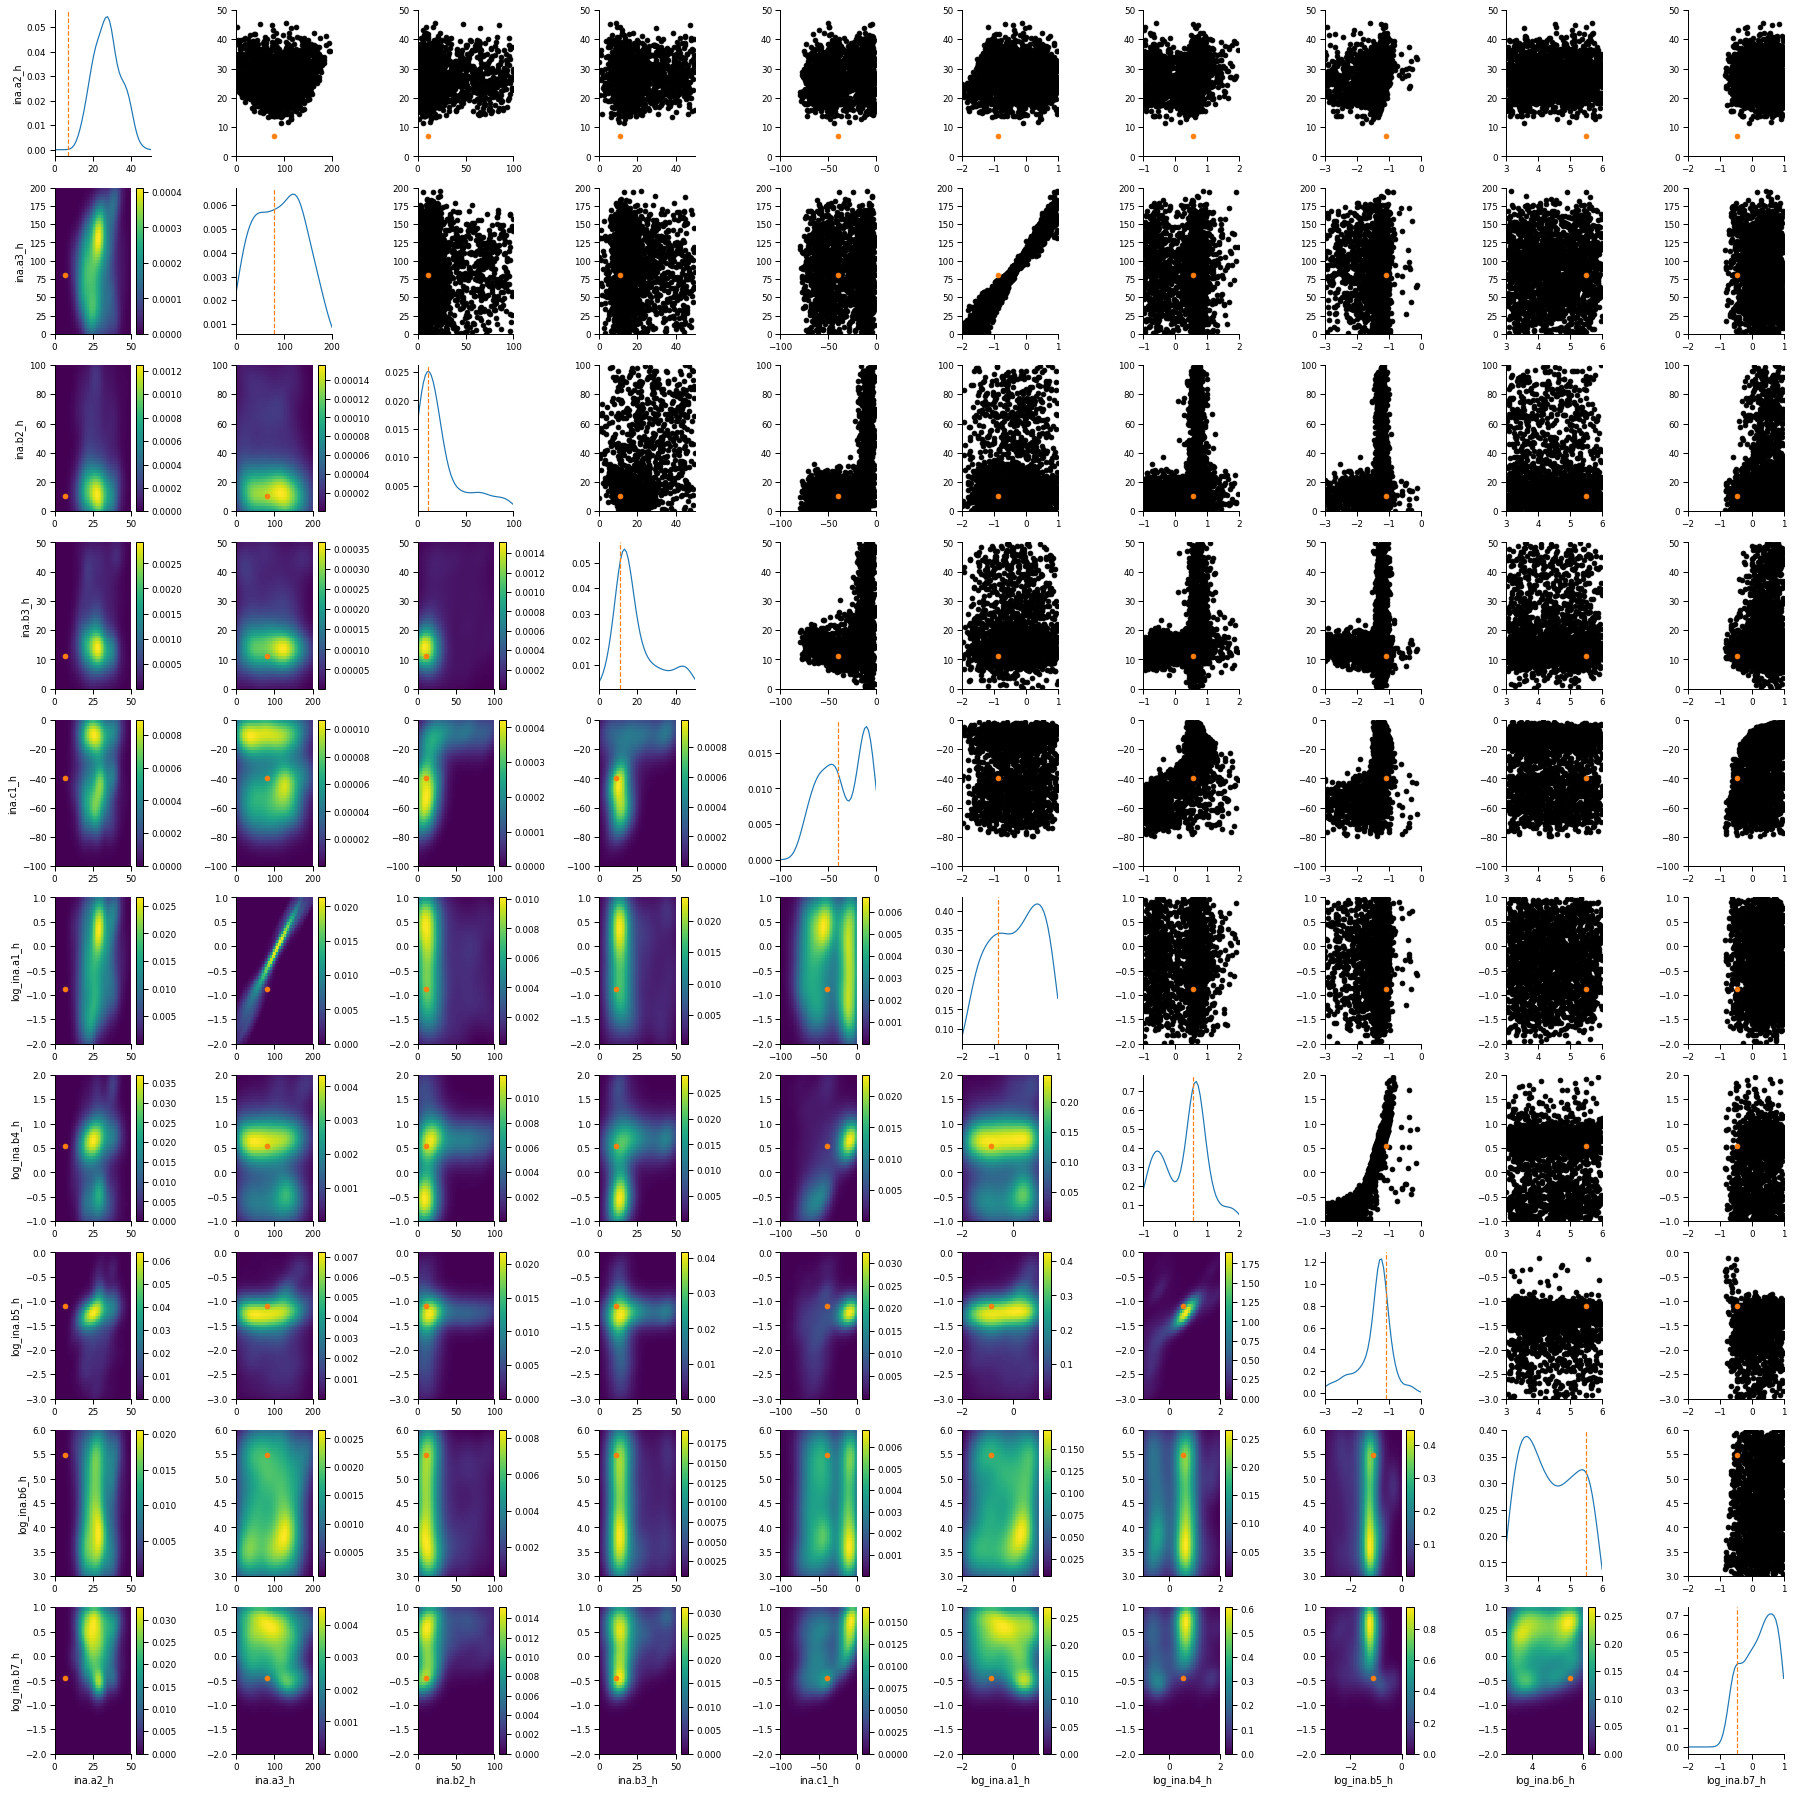

In [26]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Slow inactivation gate ($j$) calibration

In [34]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_slow,
                                                sakakibara_rec_slow)

In [35]:
assert len(observations)==len(summary_statistics(model({})))

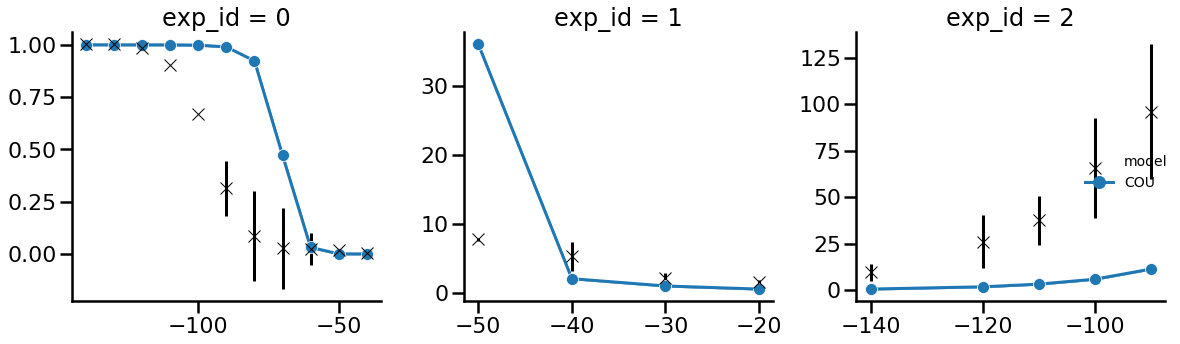

In [36]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow)

In [57]:
limits = {'ina.c1_j': (-100, 0),
          'log_ina.a1_j': (3, 7),
          'log_ina.a2_j': (-2, 2),
          'log_ina.a3_j': (-5, -1),
          'log_ina.a4_j': (-4, 0),
          #'ina.a5_j': (0, 100),
          'ina.a6_j': (0, 1),
          'ina.a7_j': (0, 100),
          #'ina.b1_j': (0, 1.0),
          #'log_ina.b2_j': (-8, -4), # set to zero as original effectively zero
          'ina.b3_j': (0, 1),
          'ina.b4_j': (0, 100),
          'ina.b5_j': (0.0, 1.0),
          'log_ina.b6_j': (-4, 0),
          'ina.b7_j': (0, 1),
          'ina.b8_j': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [58]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_jgate_original.db"))

In [59]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [60]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 8192 particles


In [61]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(8500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9818869939747233, '1': 0.9818869939747233, '2': 0.9818869939747233, '3': 0.9818869939747233, '4': 0.9818869939747233, '5': 0.3683011084316996, '6': 0.2288776196425918, '7': 0.25350563857514163, '8': 0.6324432182903594, '9': 0.9818869939747233, '10': 0.9818869939747233, '11': 2.700189233430489, '12': 0.4957538129507886, '13': 1.412898366909747, '14': 2.700189233430489, '15': 2.160151386744391, '16': 0.7192132991083816, '17': 0.7852456348032116, '18': 0.3846095367327172, '19': 0.2854129531269287}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [62]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [63]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=9, start_time=2020-01-13 17:12:25.673322, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 47298.
INFO:ABC:Acceptance rate: 8500 / 47298 = 1.7971e-01.
DEBUG:Epsilon:new eps, t=1, eps=2.8096148971541752
INFO:ABC:t: 1, eps: 2.8096148971541752.
DEBUG:ABC:Now submitting population 1.


### Analysis of results

In [65]:
history = History(db_path)

In [66]:
df, w = history.get_distribution(m=0)

In [67]:
df.describe()

name,ina.a6_j,ina.a7_j,ina.b3_j,ina.b4_j,ina.b5_j,ina.b7_j,ina.b8_j,ina.c1_j,log_ina.a1_j,log_ina.a2_j,log_ina.a3_j,log_ina.a4_j,log_ina.b6_j
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
mean,0.472623,37.068816,0.480921,59.463275,0.389263,0.388710,73.374842,-28.552460,4.949727,0.751182,-3.473260,-2.633527,-2.873703
std,0.271778,24.076817,0.268026,24.815499,0.209265,0.267537,17.645426,19.328287,1.066085,0.658238,0.417799,0.660761,0.633958
min,0.000159,0.002710,0.000063,0.006223,0.002487,0.000146,0.168798,-89.969625,3.000577,-0.820180,-4.993633,-3.999895,-3.998268
25%,0.248080,18.641574,0.258497,41.766668,0.244088,0.154249,64.672158,-37.676529,4.059308,0.233040,-3.698849,-3.150395,-3.383767
50%,0.462635,33.538725,0.478728,62.407472,0.375758,0.339317,77.288463,-25.270756,4.947009,0.759506,-3.412920,-2.562463,-2.914418
75%,0.696230,49.389839,0.694397,79.565410,0.524169,0.589420,86.060323,-14.414774,5.826013,1.275882,-3.210055,-2.080738,-2.415750
max,0.999499,99.915503,0.999966,99.972804,0.999865,0.999914,99.965001,-0.003143,6.998912,1.998630,-1.964447,-1.319365,-0.661527


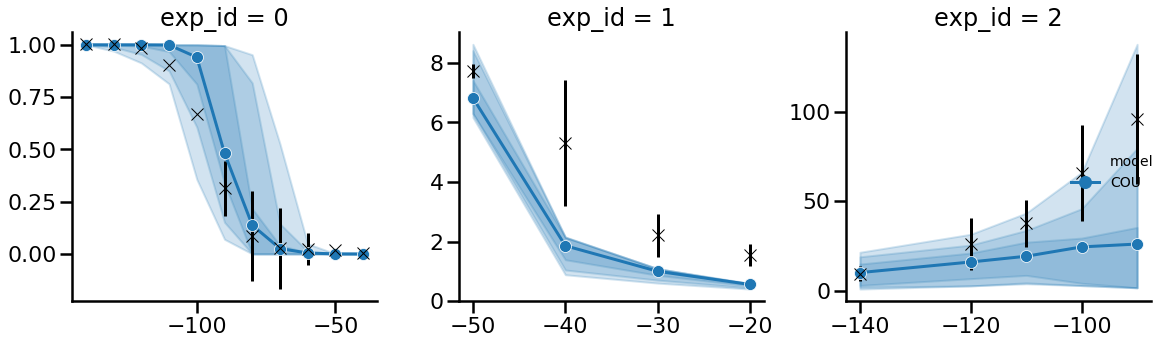

In [68]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow,
                     df=df, w=w)

plt.tight_layout()

In [69]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [70]:
m,_,_ = myokit.load(modelfile)

In [71]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

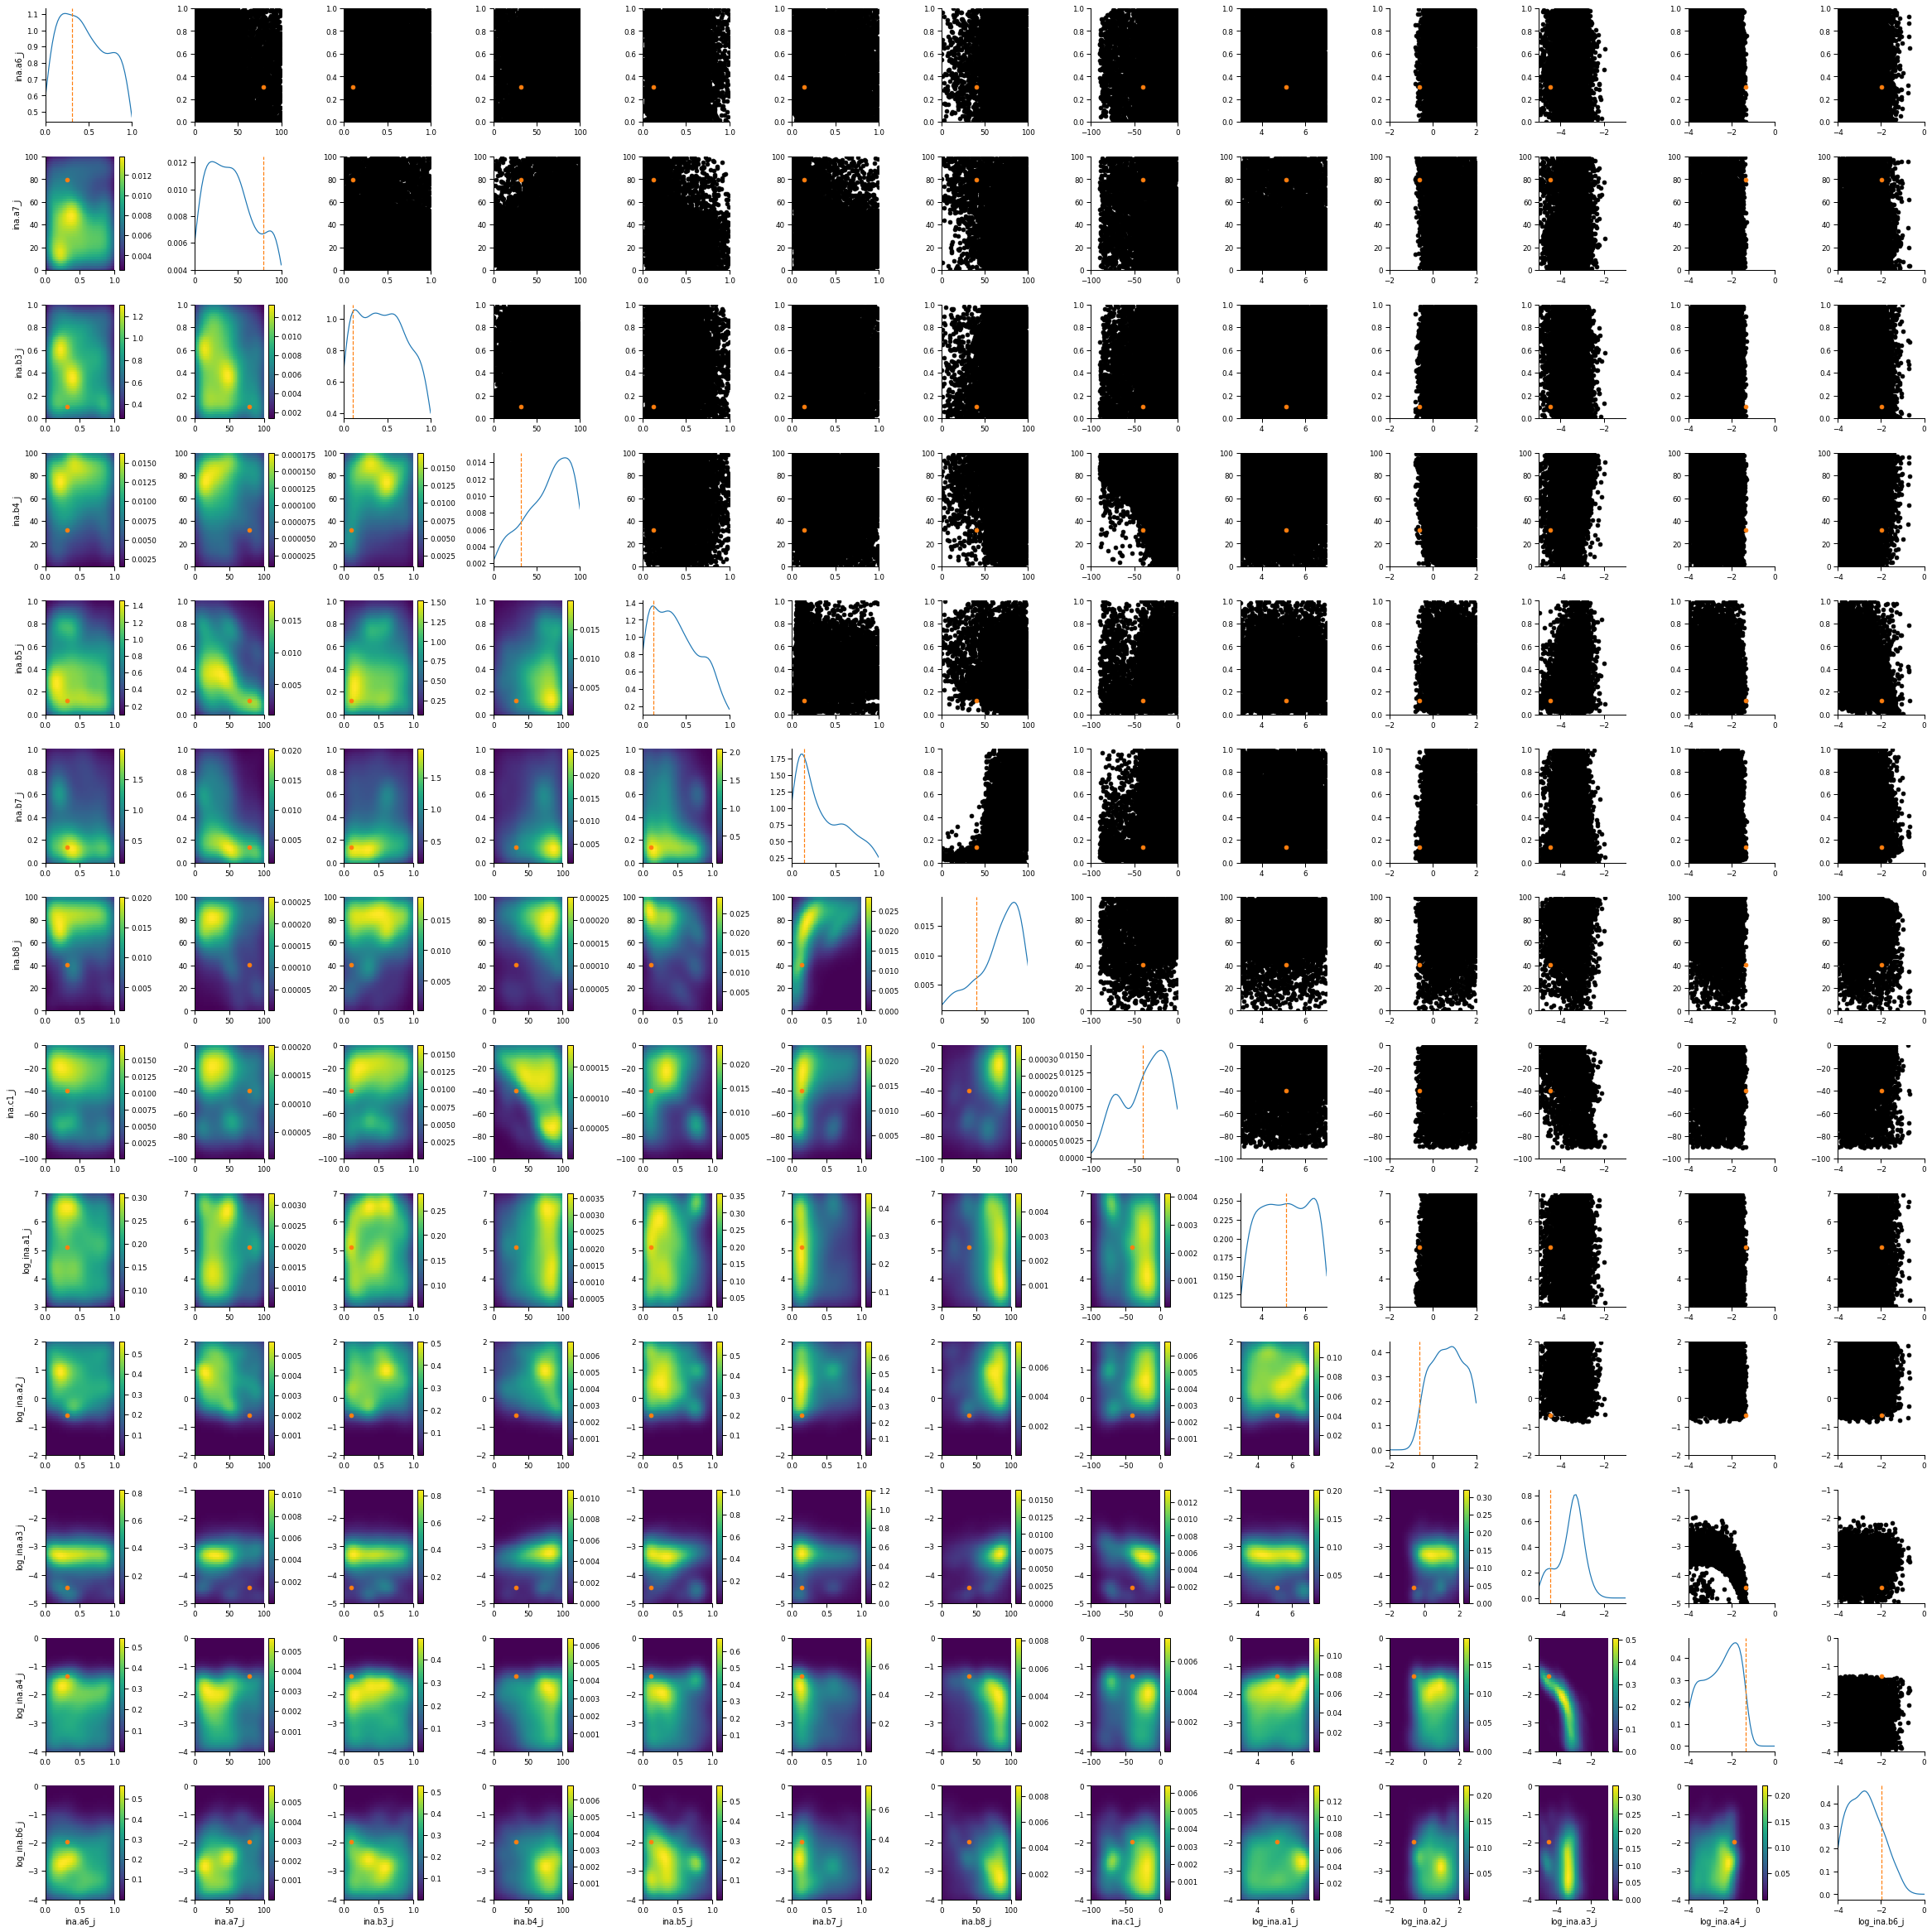

In [72]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [73]:
import pandas as pd
N = 10
cou_par_samples_j = df.sample(n=N, weights=w, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])
cou_par_samples_j = cou_par_samples_j.to_dict(orient='records')

In [74]:
from ionchannelABC.visualization import plot_variables

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


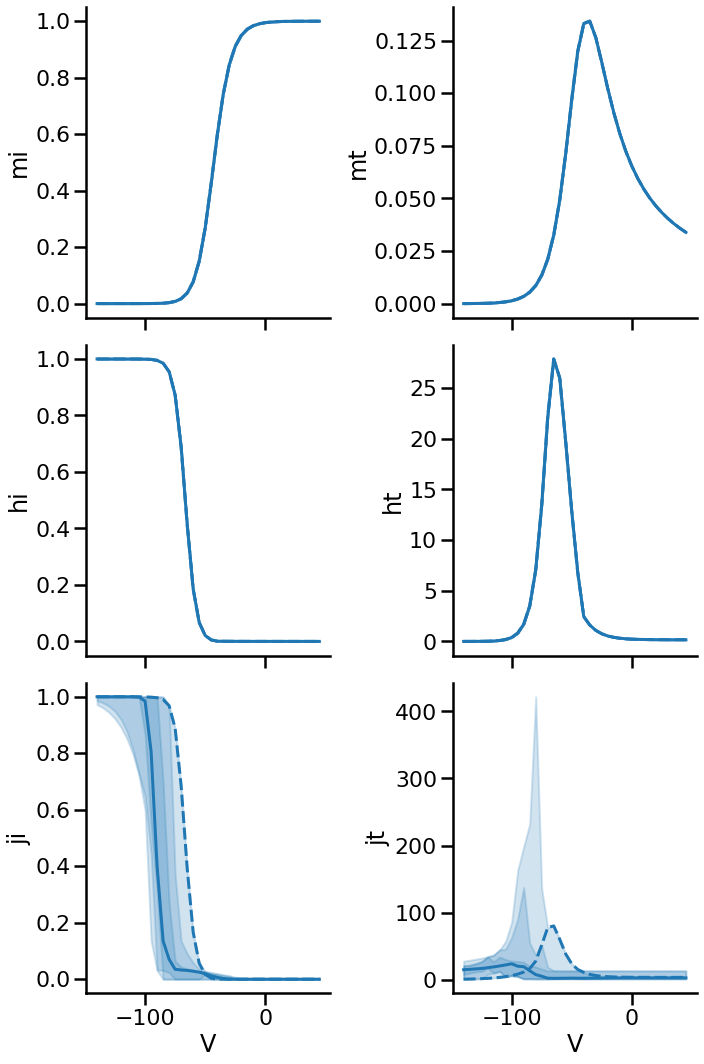

In [75]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

v = np.arange(-140, 50, 5)

cou_par_map = {'mi': 'ina.m_inf',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_inf',
               'ht': 'ina.tau_h',
               'ji': 'ina.j_inf',
               'jt': 'ina.tau_j'}

f, ax = plot_variables(v, cou_par_map,
                       ["models/courtemanche_ina.mmt"],
                       [cou_par_samples_j],
                       original=True,
                       figshape=(2,3))

plt.tight_layout()

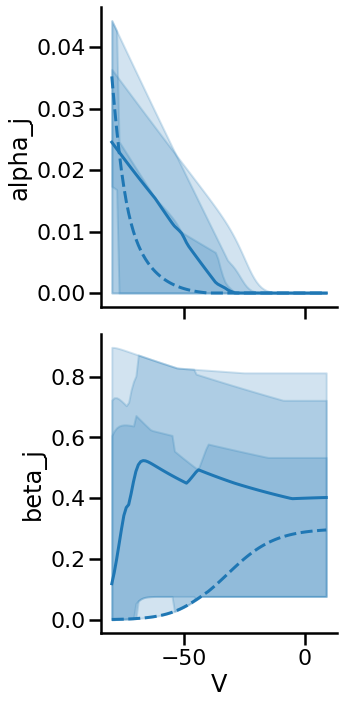

In [76]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

v = np.arange(-80, 10, 1)

cou_par_map = {'alpha_j': 'ina.alpha_j',
               'beta_j': 'ina.beta_j'}

f, ax = plot_variables(v, cou_par_map,
                       ["models/courtemanche_ina.mmt"],
                       [cou_par_samples_j],
                       original=True,
                       figshape=(1,2))
#ax[1].set_ylim([0, 0.4])

plt.tight_layout()

In [233]:
cou_par_samples_j[0]

{'ina.a6_j': 0.41301148704886725,
 'ina.a7_j': 52.6161106141938,
 'ina.b1_j': 0.7831193340019316,
 'ina.b3_j': 0.701468612495651,
 'ina.b4_j': 75.57330479413949,
 'ina.b7_j': 0.8075039406278457,
 'ina.b8_j': 93.04635174044711,
 'ina.c1_j': -7.373498107964862,
 'log_ina.a1_j': 5.996046693845665,
 'log_ina.a2_j': -0.5927309272921197,
 'log_ina.a3_j': -3.0840451102747295,
 'log_ina.a4_j': -2.2256390113967024,
 'log_ina.b2_j': -6.545348838091387,
 'log_ina.b6_j': -2.833325336109481}

In [234]:
def beta_part(V, b1, b2, b3, b4):
    return b1*np.exp(-b2*V)/(1+np.exp(-b3*(V+b4)))

In [235]:
def calc_b1(c1, b2, b3, b4, b5, b6, b7, b8):
    return b5*np.exp(-b6*c1)/(1+np.exp(-b7*(c1+b8)))*(1+np.exp(-b3*(c1+b4)))/np.exp(-b2*c1)

In [236]:
calc_b1(-4.89310260541383, 
        10**-5.850309337197719,
        0.10247765803206027,
        88.10017627036915,
        10**-1.360687617227965,
        10**-0.3200446909034119,
        0.8061796342581548,
        30.695088163032647)

0.4533174106072827

In [263]:
m,_,_ = myokit.load(modelfile)

In [268]:
V = np.arange(-100, 50, 1)

In [269]:
beta1 = [beta_part(vi, 
          m.get('ina.b5_j').value(),
          m.get('ina.b6_j').value(),
          m.get('ina.b7_j').value(),
          m.get('ina.b8_j').value()) for vi in V]

In [270]:
beta2 = [beta_part(vi, 
          m.get('ina.b1_j').value(),
          m.get('ina.b2_j').value(),
          m.get('ina.b3_j').value(),
          m.get('ina.b4_j').value()) for vi in V]

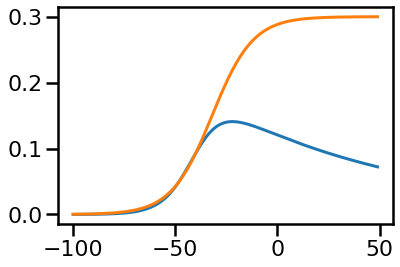

In [271]:
plt.plot(V, beta1)
plt.plot(V,beta2)